# Modeling with Pyomo

In [7]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/IDAES/idaes-pse/main/scripts/colab_helper.py"
    import colab_helper
    colab_helper.install_idaes()
    colab_helper.install_ipopt()
    

This page is [adapted from our process control class](https://github.com/ndcbe/controls/blob/main/notebooks/06.02-Simulation-and-Open-Loop-Optimal-Control.ipynb) at Notre Dame; it was developed by Prof. Jeff Kantor.

Now we want to define our TCLab model in Pyomo. Recall the two-state model for a single heater/sensor assembly:

\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_b (T_S - T_H) + \alpha P u(t) + d(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H) 
\end{align*}

Let's start by defining some model coefficients:

In [8]:
# parameters
alpha = 0.00016       # watts / (units P * percent U1)
P = 200               # P units
Ua = 0.050            # heat transfer coefficient from heater to environment
CpH = 2.2             # heat capacity of the heater (J/deg C)
CpS = 1.9             # heat capacity of the sensor (J/deg C)
Ub = 0.021            # heat transfer coefficient from heater to sensor
Tamb = 21.0           # ambient temperature

## Simulate a Step Test (ramp)

Let's establish a goal of bringing the heater temperature to 60 deg C.  Let's see how well an initial guess at a control strategy will work for us subject to initial conditions

$$
\begin{align*}
T_H(t_0) & = T_{amb} \\
T_S(t_0) & = T_{amb}
\end{align*}
$$

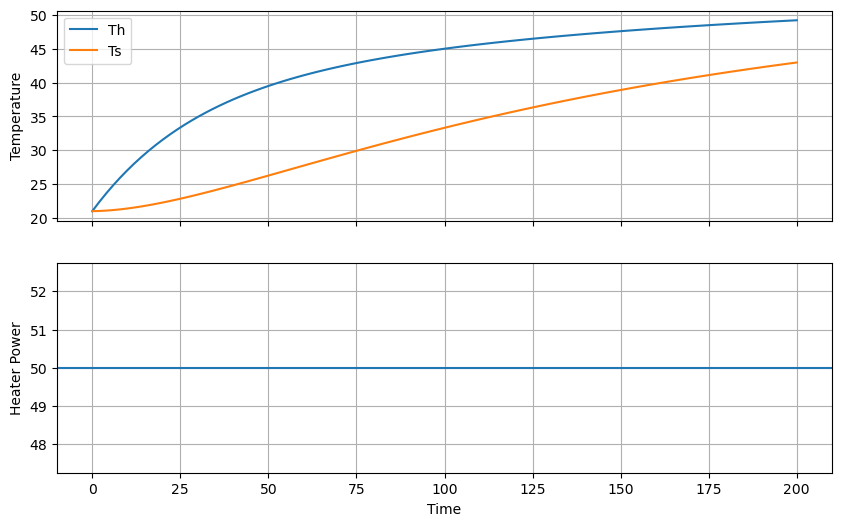

In [9]:
# final time [seconds]
tf = 200

# control input [%]
u = 50.0

# import Pyomo library
import pyomo.environ as pyo
import pyomo.dae as dae

# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th = pyo.Var(m.t)
m.Ts = pyo.Var(m.t)

# Define the derivatives of the state variables
m.dTh = dae.DerivativeVar(m.Th)
m.dTs = dae.DerivativeVar(m.Ts)

# Define the first differential equation
@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh[t] == Ua *(Tamb - m.Th[t]) + Ub*(m.Ts[t] - m.Th[t]) + alpha*P*u

# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs[t] == Ub *(m.Th[t] - m.Ts[t]) 

# Set the initial conditions
m.Th[0].fix(Tamb)
m.Ts[0].fix(Tamb)

# Apply a finite difference formula to numerically integrate the differential equations
pyo.TransformationFactory('dae.finite_difference').apply_to(m, nfe=100, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

# Plot the results
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# Plot 1: Temperature
ax[0].plot(m.t, [m.Th[t]() for t in m.t], label="Th")
ax[0].plot(m.t, [m.Ts[t]() for t in m.t], label="Ts")
ax[0].legend()
ax[0].set_ylabel("Temperature")
ax[0].grid()

# Plot 2: Heater Power
ax[1].axhline(u, label="Power")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Heater Power")
ax[1].grid()


## Activity

Modify the code above to find the value for `u` that causes `Th` to reach 60 deg C at the final time.

## Feedforward Optimal Control

An optimal control policy minimizes the differences

$$
\begin{align*}
\min_{u} \int_{t_0}^{t_f} \|SP(t) - T_H(t)\|^2\,dt \\
\end{align*}
$$

subject to constraints

$$
\begin{align*}
C_p^H \frac{dT_H}{dt} & = U_a (T_{amb} - T_H) + U_c (T_S - T_H) + \alpha P u(t)\\
C_p^S \frac{dT_S}{dt} & = - U_c (T_S - T_H)  \\
\\
\text{control limits}\qquad0 \leq u(t) & \leq 100.0
\\
\text{initial condition}\qquad T_H(t_0) & = T_{amb} \\
\text{initial condition}\qquad T_S(t_0) & = T_{amb}
\end{align*}
$$


and prior knowledge of $d(t)$. Note that `pyomo.dae` has an `Integral` object to help with these situations.

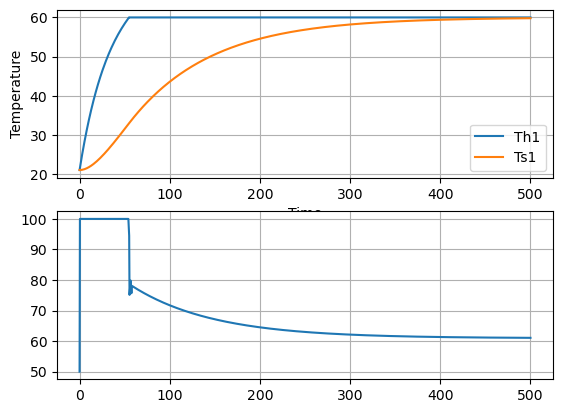

In [10]:
# Set point, deg C
SP = 60.0

# Final time, seconds
tf = 500.0

# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th1 = pyo.Var(m.t)
m.Ts1 = pyo.Var(m.t)

# Define the derivatives of the state variables
m.dTh1 = dae.DerivativeVar(m.Th1)
m.dTs1 = dae.DerivativeVar(m.Ts1)

# Define the control variable (heater power) as a function of time
m.u1 = pyo.Var(m.t, bounds=(0, 100))

# Define the integral of the squared error
@m.Integral(m.t)
def ise(m, t):
    return (SP - m.Th1[t])**2

# Define the first differential equation
@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh1[t] == Ua *(Tamb - m.Th1[t]) + Ub*(m.Ts1[t] - m.Th1[t]) + alpha*P*m.u1[t]

# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs1[t] == Ub *(m.Th1[t] - m.Ts1[t]) 

# Set the initial conditions
m.Th1[0].fix(Tamb)
m.Ts1[0].fix(Tamb)
                           
# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise

# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

# Plot the results
fig, ax = plt.subplots(2, 1)

ax[0].plot(m.t, [m.Th1[t]() for t in m.t], label="Th1")
ax[0].plot(m.t, [m.Ts1[t]() for t in m.t], label="Ts1")
ax[0].legend()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].plot(m.t, [m.u1[t]() for t in m.t], label="U1")
ax[1].grid()

## Controlling to a Reference Tractory

The reference trajectory is a sequence of ramp/soak intervals.  Python function `r(t)` uses `numpy.interp` to compute values of the reference trajectory at any point in time.

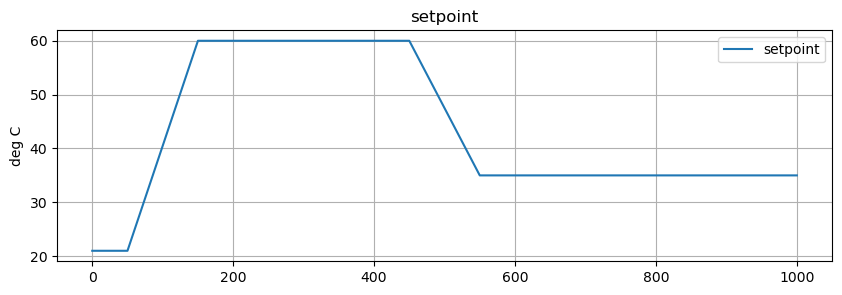

In [11]:
import numpy as np

# time grid
tf = 1000
dt = 2
n = round(tf/dt)
t_grid = np.linspace(0, 1000, n+1)

# ambient temperature
Tamb = 21

# setpoint/reference
def r(t):
    return np.interp(t, [0, 50, 150, 450, 550], [Tamb, Tamb, 60, 60, 35])

# plot function
fig, ax = plt.subplots(1, 1, figsize=(10, 3))
ax.plot(t_grid, r(t_grid), label="setpoint")
ax.set_title('setpoint')
ax.set_ylabel('deg C')
ax.legend()
ax.grid(True)

Now let's solve the optimal control problem to find a control policy $u(t)$ for the interval $0 \leq t \leq t_f$ which causes the output $y(t)$ to track a desired setpoint or reference tracjectory $r(t)$.

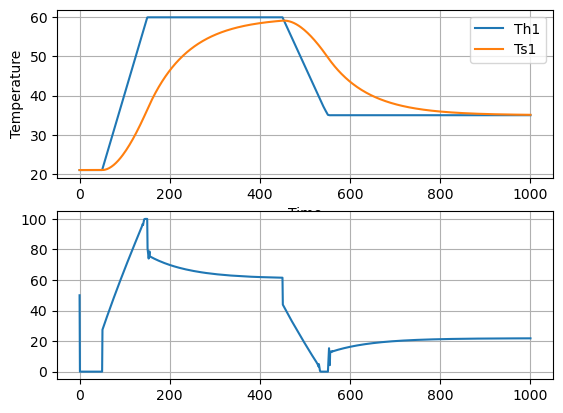

In [12]:
# Create a Pyomo model
m = pyo.ConcreteModel('TCLab Heater/Sensor')

# Define time domain
m.t = dae.ContinuousSet(bounds=(0, tf))

# Define the state variables as a function of time
m.Th1 = pyo.Var(m.t)
m.Ts1 = pyo.Var(m.t)

# Define the derivatives of the state variables
m.dTh1 = dae.DerivativeVar(m.Th1)
m.dTs1 = dae.DerivativeVar(m.Ts1)

# Define the control variable (heater power) as a function of time
m.u1 = pyo.Var(m.t, bounds=(0, 100))

# Define the integral of the squared error
@m.Integral(m.t)
def ise(m, t):
    return (r(t) - m.Th1[t])**2

# Define the first differential equation
@m.Constraint(m.t)
def heater1(m, t):
    return CpH * m.dTh1[t] == Ua *(Tamb - m.Th1[t]) + Ub*(m.Ts1[t] - m.Th1[t]) + alpha*P*m.u1[t]

# Define the second differential equation
@m.Constraint(m.t)
def sensor1(m, t):
    return CpS * m.dTs1[t] == Ub *(m.Th1[t] - m.Ts1[t]) 

# Fix the initial conditions
m.Th1[0].fix(Tamb)
m.Ts1[0].fix(Tamb)
                           
# Define the objective function
@m.Objective(sense=pyo.minimize)
def objective(m):
    return m.ise

# Apply a collocation method to numerically integrate the differential equations
pyo.TransformationFactory('dae.collocation').apply_to(m, nfe=200, wrt=m.t)

# Call our nonlinear optimization/equation solver, Ipopt
pyo.SolverFactory('ipopt').solve(m)

# Plot the results
fig, ax = plt.subplots(2, 1)

ax[0].plot(m.t, [m.Th1[t]() for t in m.t], label="Th1")
ax[0].plot(m.t, [m.Ts1[t]() for t in m.t], label="Ts1")
ax[0].legend()
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Temperature")
ax[0].grid()

ax[1].plot(m.t, [m.u1[t]() for t in m.t], label="U1")
ax[1].grid()

## Take Away Messages

This example shows two things:
1. Pyomo is a great environment to formulate and solve optimization problems.
2. Predictive models are critical for intelligent decision making.

For the result of the workshop, we will use Pyomo to:
1. Estimate the model parameters in the TCLab model from experimental data.
2. Determine the most informative next experiment to reduce uncertainty in the model parameters.

To simplify the code, we have prepared some helper functions to assemble Pyomo models and manipulate data. Please spend the next 10 minutes studying [tcklab_pyomo.py](https://github.com/dowlinglab/pyomo-doe/blob/main/notebooks/tclab_pyomo.py)